![](../docs/banner.png)

# Appendix D: Creating a CNN to Predict Bitmojis

In [1]:
import numpy as np
import torch
from PIL import Image
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torchsummary import summary
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'axes.grid': False})

## 1. Introduction
<hr>

This code-based appendix contains the code needed to develop and save the Bitmoji CNN's I use in [Chapter 6](chapter6_cnns-pt2.ipynb).

## 2. CNN from Scratch
<hr>

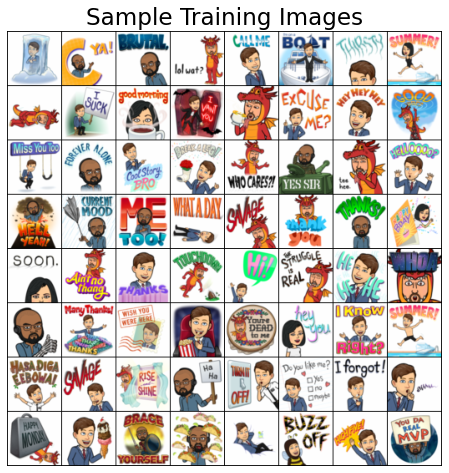

In [2]:
TRAIN_DIR = "data/bitmoji_rgb/train/"
VALID_DIR = "data/bitmoji_rgb/valid/"
IMAGE_SIZE = 64
BATCH_SIZE = 64

# Transforms
data_transforms = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
# Load data and create dataloaders
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataset = datasets.ImageFolder(root=VALID_DIR, transform=data_transforms)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Plot samples
sample_batch = next(iter(trainloader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

In [5]:
class bitmoji_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 8, (5, 5)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(8, 4, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((3, 3)),
            nn.Flatten(),
            nn.Linear(324, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [7]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    """Training wrapper for PyTorch network."""
    
    train_loss, valid_loss, valid_accuracy = [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        model.train()
        for X, y in trainloader:
            optimizer.zero_grad()
            y_hat = model(X).flatten()
            loss = criterion(y_hat, y.type(torch.float32))
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
        train_loss.append(train_batch_loss / len(trainloader))
        
        # Validation
        model.eval()
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                y_hat = model(X).flatten()
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat, y.type(torch.float32))
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}
    return results    

In [6]:
# Define and train model
model = bitmoji_CNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
results = trainer(model, criterion, optimizer, trainloader, validloader, epochs=20)

Epoch 1: Train Loss: 0.692. Valid Loss: 0.685. Valid Accuracy: 0.64.
Epoch 2: Train Loss: 0.670. Valid Loss: 0.666. Valid Accuracy: 0.56.
Epoch 3: Train Loss: 0.646. Valid Loss: 0.639. Valid Accuracy: 0.63.
Epoch 4: Train Loss: 0.623. Valid Loss: 0.620. Valid Accuracy: 0.67.
Epoch 5: Train Loss: 0.614. Valid Loss: 0.612. Valid Accuracy: 0.63.
Epoch 6: Train Loss: 0.589. Valid Loss: 0.550. Valid Accuracy: 0.75.
Epoch 7: Train Loss: 0.570. Valid Loss: 0.520. Valid Accuracy: 0.77.
Epoch 8: Train Loss: 0.555. Valid Loss: 0.510. Valid Accuracy: 0.76.
Epoch 9: Train Loss: 0.537. Valid Loss: 0.545. Valid Accuracy: 0.72.
Epoch 10: Train Loss: 0.527. Valid Loss: 0.530. Valid Accuracy: 0.74.
Epoch 11: Train Loss: 0.503. Valid Loss: 0.483. Valid Accuracy: 0.78.
Epoch 12: Train Loss: 0.479. Valid Loss: 0.434. Valid Accuracy: 0.81.
Epoch 13: Train Loss: 0.458. Valid Loss: 0.447. Valid Accuracy: 0.80.
Epoch 14: Train Loss: 0.438. Valid Loss: 0.435. Valid Accuracy: 0.80.
Epoch 15: Train Loss: 0.421. 

In [7]:
# Save model
PATH = "models/bitmoji_cnn.pt"
torch.save(model, PATH)

## 2. CNN from Scratch with Data Augmentation
<hr>

Consider the "Tom" Bitmoji below:

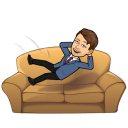

In [9]:
image = Image.open('img/tom-bitmoji.png')
image

You can tell it's a me (class "Tom"), can my CNN?

In [10]:
image_tensor = transforms.functional.to_tensor(image.resize((IMAGE_SIZE, IMAGE_SIZE))).unsqueeze(0)
prediction = int(torch.sigmoid(model(image_tensor)) > 0.5)
print(f"Prediction: {train_dataset.classes[prediction]}")

Prediction: tom


Great! But what happens if I flip my image like this:

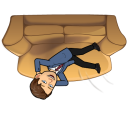

In [11]:
image = image.rotate(180)
image

You can still tell that it's me, but can my CNN?

In [12]:
image_tensor = transforms.functional.to_tensor(image.resize((IMAGE_SIZE, IMAGE_SIZE))).unsqueeze(0)
prediction = int(torch.sigmoid(model(image_tensor)) > 0.5)
print(f"Prediction: {train_dataset.classes[prediction]}")

Prediction: tom


Looks like our CNN is not very robust to rotational changes in our input image. We could try and fix that using some data augmentation, let's do that now:

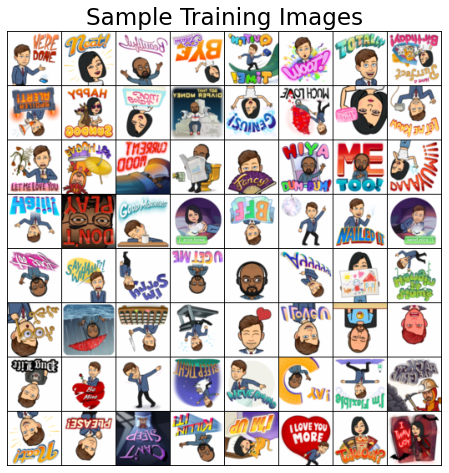

In [3]:
# Transforms
data_transforms = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()])

# Load data and re-create training loader
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Plot samples
sample_batch = next(iter(trainloader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

Okay, let's train again with our new augmented dataset:

In [8]:
# Define and train model
model = bitmoji_CNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
results = trainer(model, criterion, optimizer, trainloader, validloader, epochs=40)

Epoch 1: Train Loss: 0.694. Valid Loss: 0.693. Valid Accuracy: 0.50.
Epoch 2: Train Loss: 0.692. Valid Loss: 0.691. Valid Accuracy: 0.56.
Epoch 3: Train Loss: 0.689. Valid Loss: 0.677. Valid Accuracy: 0.62.
Epoch 4: Train Loss: 0.674. Valid Loss: 0.674. Valid Accuracy: 0.53.
Epoch 5: Train Loss: 0.656. Valid Loss: 0.637. Valid Accuracy: 0.65.
Epoch 6: Train Loss: 0.643. Valid Loss: 0.636. Valid Accuracy: 0.60.
Epoch 7: Train Loss: 0.632. Valid Loss: 0.599. Valid Accuracy: 0.67.
Epoch 8: Train Loss: 0.612. Valid Loss: 0.611. Valid Accuracy: 0.66.
Epoch 9: Train Loss: 0.606. Valid Loss: 0.584. Valid Accuracy: 0.67.
Epoch 10: Train Loss: 0.591. Valid Loss: 0.555. Valid Accuracy: 0.74.
Epoch 11: Train Loss: 0.580. Valid Loss: 0.614. Valid Accuracy: 0.63.
Epoch 12: Train Loss: 0.575. Valid Loss: 0.546. Valid Accuracy: 0.74.
Epoch 13: Train Loss: 0.562. Valid Loss: 0.532. Valid Accuracy: 0.77.
Epoch 14: Train Loss: 0.552. Valid Loss: 0.531. Valid Accuracy: 0.75.
Epoch 15: Train Loss: 0.550. 

In [13]:
# Save model
PATH = "models/bitmoji_cnn_augmented.pt"
torch.save(model, PATH)

Let's try predict this one again:

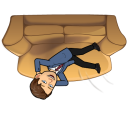

In [79]:
image

In [78]:
image_tensor = transforms.functional.to_tensor(image.resize((IMAGE_SIZE, IMAGE_SIZE))).unsqueeze(0)
prediction = int(torch.sigmoid(model(image_tensor)) > 0.5)
print(f"Prediction: {train_dataset.classes[prediction]}")

Prediction: tom


Got it now!